In [1]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load data
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
X = df.drop(columns=["Diabetes_binary"])
y = df["Diabetes_binary"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline: SMOTE + Scaling + MLP
mlp_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(100, 50, 25),
        activation='relu',
        solver='adam',
        early_stopping=True,
        max_iter=1000,
        random_state=42
    ))
])

# Grid Search for tuning
param_grid = {
    "mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01],
    "mlp__batch_size": [64, 128]
}

grid = GridSearchCV(mlp_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74      7070
         1.0       0.73      0.80      0.76      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



In [8]:
param_grid = {
    "mlp__alpha": [0.00001, 0.0001, 0.001, 0.01],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__batch_size": [32, 64, 128],
    "mlp__hidden_layer_sizes": [(100,), (100, 50), (100, 50, 25)]
}

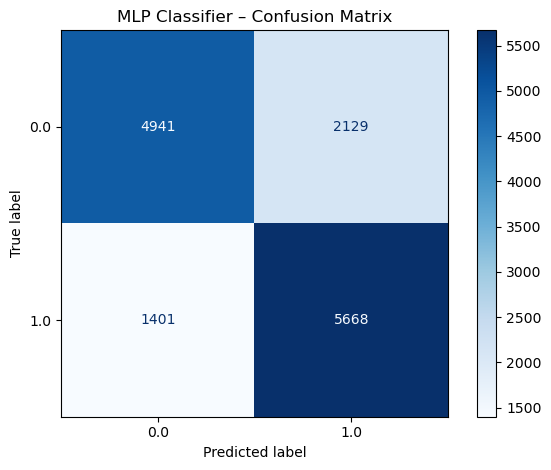

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap='Blues')
plt.title("MLP Classifier – Confusion Matrix")
plt.tight_layout()
plt.show()


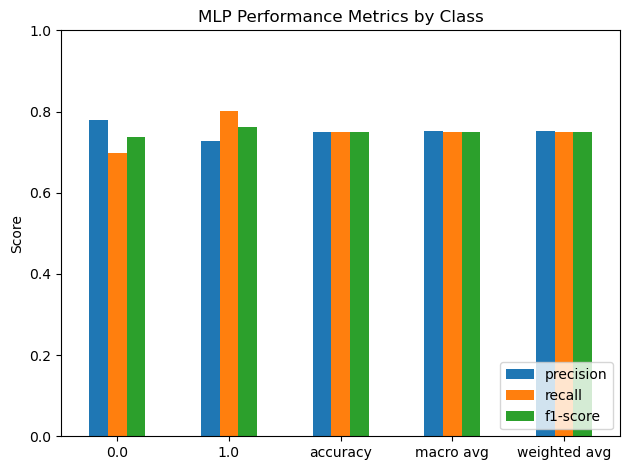

In [12]:
from sklearn.metrics import classification_report
import seaborn as sns

# Generate predictions and report
y_pred = grid.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Prepare for barplot
metrics_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude accuracy row
metrics_df.plot(kind='bar')
plt.title("MLP Performance Metrics by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


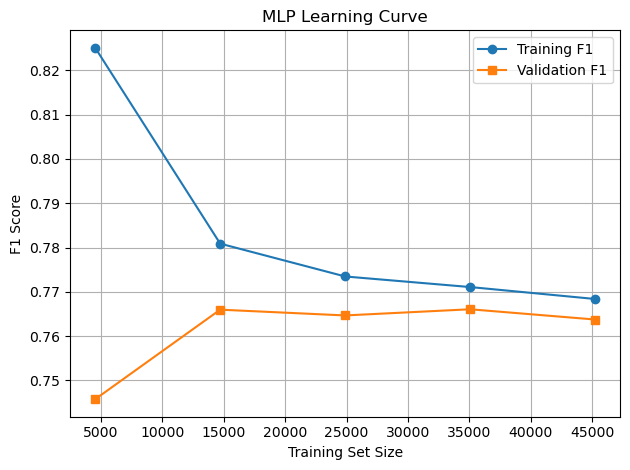

In [14]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', label='Training F1')
plt.plot(train_sizes, val_mean, 's-', label='Validation F1')
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("MLP Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


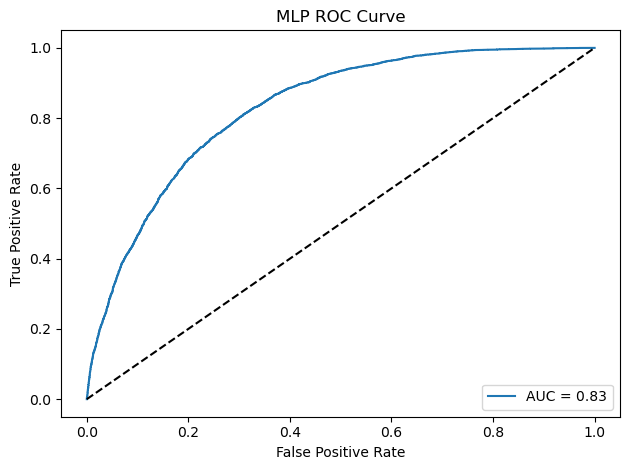

In [16]:
from sklearn.metrics import roc_curve, auc

y_score = grid.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()